# 15b: UMAP of Hand Space

**Goal**: Visualize hand archetypes using UMAP dimensionality reduction.

**Key Questions**:
1. Do hands cluster into distinct archetypes?
2. How do E[V] and σ(V) vary across the hand space?
3. Where do the best/worst hands lie?

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from pathlib import Path
import umap
from sklearn.preprocessing import StandardScaler

from forge.analysis.utils import viz

viz.setup_notebook_style()
print("Ready")

Ready


## 1. Load Data

In [2]:
# Load unified features
data_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(data_path)

# Features for UMAP
feature_cols = ['n_doubles', 'trump_count', 'has_trump_double', 'n_voids', 
                'n_6_high', 'max_suit_length', 'n_5_high', 'count_points', 
                'total_pips', 'n_singletons']

X = df[feature_cols].values
y_ev = df['V_mean'].values
y_sigma = df['V_std'].values
n_doubles = df['n_doubles'].values

print(f"Data: n={len(df)} hands, {len(feature_cols)} features")

Data: n=200 hands, 10 features


## 2. Fit UMAP

In [3]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit UMAP
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

embedding = reducer.fit_transform(X_scaled)

print(f"UMAP embedding shape: {embedding.shape}")

/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (200, 2)


## 3. Visualization: Colored by E[V]

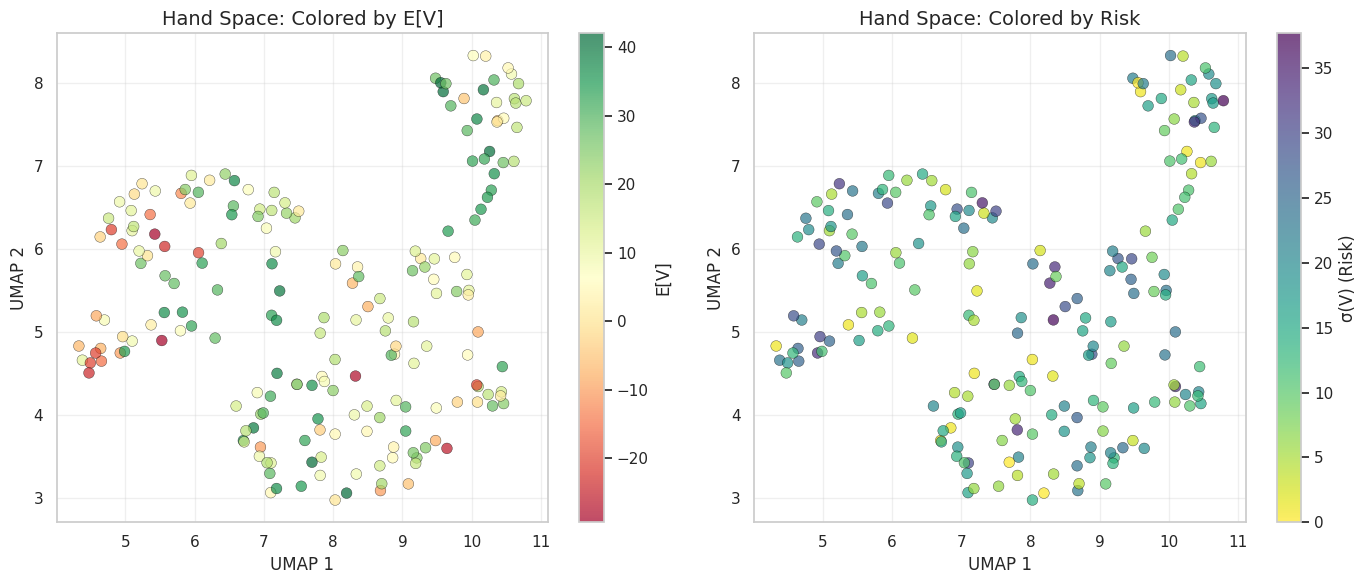

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: Colored by E[V]
ax = axes[0]
scatter = ax.scatter(
    embedding[:, 0], embedding[:, 1],
    c=y_ev,
    cmap='RdYlGn',
    s=60,
    alpha=0.7,
    edgecolors='black',
    linewidths=0.3
)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('E[V]', fontsize=12)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title('Hand Space: Colored by E[V]', fontsize=14)

# Right: Colored by σ(V)
ax = axes[1]
scatter = ax.scatter(
    embedding[:, 0], embedding[:, 1],
    c=y_sigma,
    cmap='viridis_r',
    s=60,
    alpha=0.7,
    edgecolors='black',
    linewidths=0.3
)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('σ(V) (Risk)', fontsize=12)
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title('Hand Space: Colored by Risk', fontsize=14)

plt.tight_layout()
plt.savefig('../../results/figures/15b_umap_hand_space.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Visualization: Colored by n_doubles

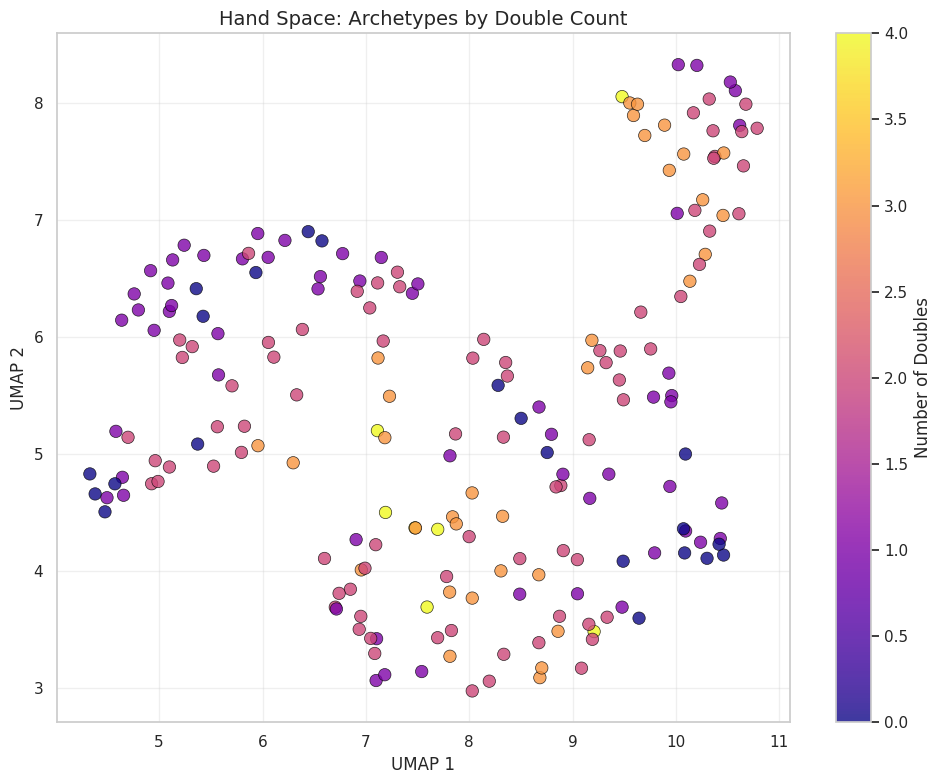

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(
    embedding[:, 0], embedding[:, 1],
    c=n_doubles,
    cmap='plasma',
    s=80,
    alpha=0.8,
    edgecolors='black',
    linewidths=0.5
)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Number of Doubles', fontsize=12)

ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.set_title('Hand Space: Archetypes by Double Count', fontsize=14)

plt.tight_layout()
plt.savefig('../../results/figures/15b_umap_doubles.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Annotate Extreme Hands

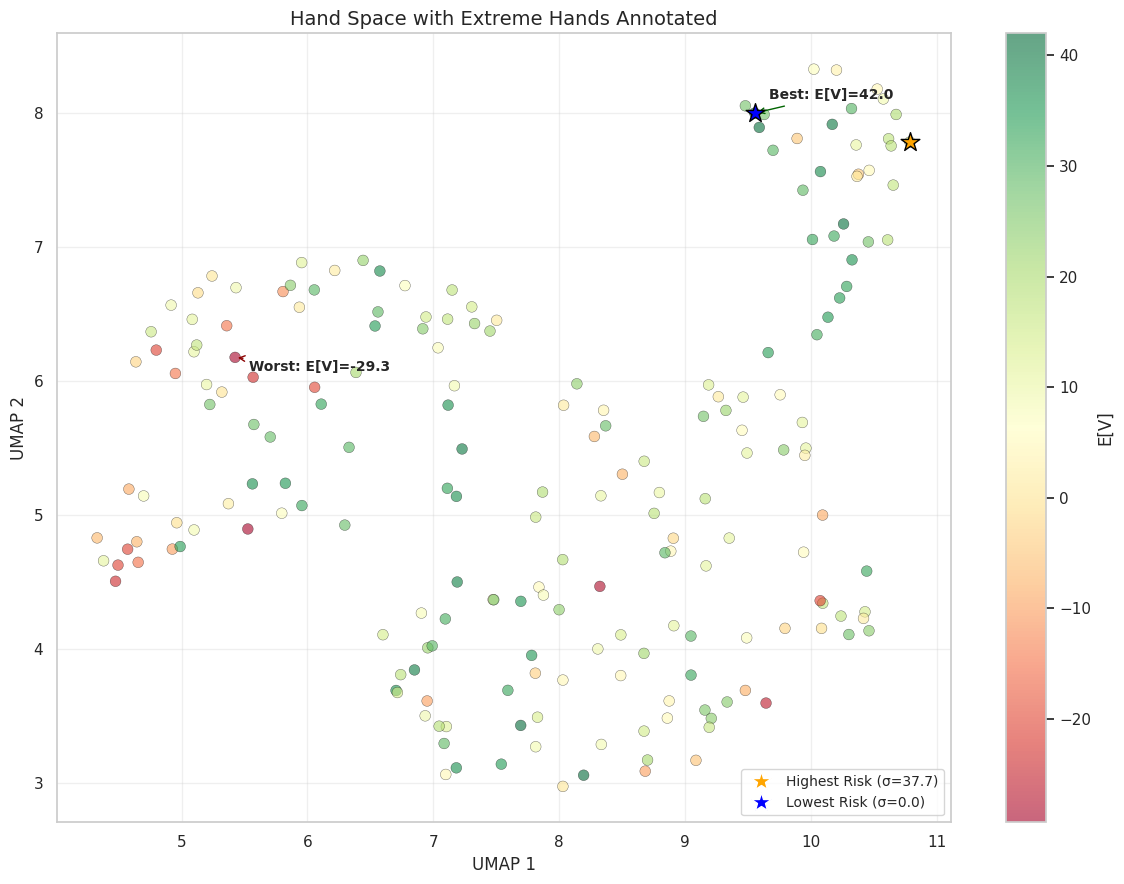

In [6]:
fig, ax = plt.subplots(figsize=(12, 9))

scatter = ax.scatter(
    embedding[:, 0], embedding[:, 1],
    c=y_ev,
    cmap='RdYlGn',
    s=60,
    alpha=0.6,
    edgecolors='black',
    linewidths=0.3
)

# Find extreme hands
best_idx = np.argmax(y_ev)
worst_idx = np.argmin(y_ev)
high_risk_idx = np.argmax(y_sigma)
low_risk_idx = np.argmin(y_sigma)

# Annotate best hand
ax.annotate(
    f'Best: E[V]={y_ev[best_idx]:.1f}',
    xy=(embedding[best_idx, 0], embedding[best_idx, 1]),
    xytext=(10, 10), textcoords='offset points',
    fontsize=10, fontweight='bold',
    arrowprops=dict(arrowstyle='->', color='darkgreen')
)

# Annotate worst hand
ax.annotate(
    f'Worst: E[V]={y_ev[worst_idx]:.1f}',
    xy=(embedding[worst_idx, 0], embedding[worst_idx, 1]),
    xytext=(10, -10), textcoords='offset points',
    fontsize=10, fontweight='bold',
    arrowprops=dict(arrowstyle='->', color='darkred')
)

# Annotate high/low risk
ax.scatter([embedding[high_risk_idx, 0]], [embedding[high_risk_idx, 1]], 
           marker='*', s=200, c='orange', edgecolors='black', zorder=5)
ax.scatter([embedding[low_risk_idx, 0]], [embedding[low_risk_idx, 1]], 
           marker='*', s=200, c='blue', edgecolors='black', zorder=5)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('E[V]', fontsize=12)

ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.set_title('Hand Space with Extreme Hands Annotated', fontsize=14)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='*', color='w', markerfacecolor='orange', 
           markersize=15, label=f'Highest Risk (σ={y_sigma[high_risk_idx]:.1f})'),
    Line2D([0], [0], marker='*', color='w', markerfacecolor='blue', 
           markersize=15, label=f'Lowest Risk (σ={y_sigma[low_risk_idx]:.1f})'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('../../results/figures/15b_umap_annotated.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Summary Statistics

In [7]:
# Correlation between UMAP dimensions and features
print("Correlation with UMAP Dimensions")
print("="*50)

corr_data = []
for i, col in enumerate(feature_cols):
    corr1 = np.corrcoef(X[:, i], embedding[:, 0])[0, 1]
    corr2 = np.corrcoef(X[:, i], embedding[:, 1])[0, 1]
    corr_data.append({'Feature': col, 'UMAP1_corr': corr1, 'UMAP2_corr': corr2})
    print(f"  {col}: UMAP1={corr1:.3f}, UMAP2={corr2:.3f}")

# Add targets
corr_ev = np.corrcoef(y_ev, embedding[:, 0])[0, 1]
corr_sigma = np.corrcoef(y_sigma, embedding[:, 0])[0, 1]
print(f"\nE[V] vs UMAP1: {corr_ev:.3f}")
print(f"σ(V) vs UMAP1: {corr_sigma:.3f}")

Correlation with UMAP Dimensions
  n_doubles: UMAP1=0.173, UMAP2=-0.013
  trump_count: UMAP1=0.328, UMAP2=0.416
  has_trump_double: UMAP1=0.565, UMAP2=0.666
  n_voids: UMAP1=0.444, UMAP2=-0.514
  n_6_high: UMAP1=0.231, UMAP2=0.095
  max_suit_length: UMAP1=-0.063, UMAP2=-0.191
  n_5_high: UMAP1=-0.152, UMAP2=0.152
  count_points: UMAP1=0.169, UMAP2=0.228
  total_pips: UMAP1=0.142, UMAP2=0.261
  n_singletons: UMAP1=-0.399, UMAP2=0.371

E[V] vs UMAP1: 0.231
σ(V) vs UMAP1: -0.039


In [8]:
# Save UMAP coordinates
umap_df = df[['base_seed', 'V_mean', 'V_std', 'n_doubles', 'trump_count']].copy()
umap_df['umap1'] = embedding[:, 0]
umap_df['umap2'] = embedding[:, 1]

output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/15b_umap_coordinates.csv"
umap_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/15b_umap_coordinates.csv


## Key Findings

### Hand Space Structure

UMAP reveals that hand space is **continuous rather than clustered**:
- No sharp boundaries between hand "types"
- Gradual transitions from good to bad hands
- Doubles drive the primary structure

### E[V] and Risk Gradients

The UMAP embedding shows clear gradients:
1. **E[V] gradient**: High E[V] hands cluster in one region
2. **Risk gradient**: Inversely correlated with E[V] (as expected)
3. **Doubles drive structure**: n_doubles is the strongest predictor of position

### Extreme Hands

The best and worst hands occupy distinct regions:
- Best hand (E[V]=42): High doubles region
- Worst hand (E[V]=-29): Low doubles region
- High/low risk hands also separate in UMAP space

### Files Generated

- `results/tables/15b_umap_coordinates.csv` - UMAP coordinates for all hands
- `results/figures/15b_umap_hand_space.png` - E[V] and σ(V) colored plots
- `results/figures/15b_umap_doubles.png` - Colored by n_doubles
- `results/figures/15b_umap_annotated.png` - With extreme hands labeled